# Titanic Machine Learning Competition

## Model Creating, Training & Testing
- In this notebook we will create a ML model to predict which passengers survive the Titanic.
  - I will create 2 different models:
    - A Neural Network (Dense)
    - RandomForestClassifier
  - I'll compare both models and pick the one that performs best
- We will also be training and testing the model to ensure predictions are accurate.
- Finally, I will create plots for visualizing and analyzing overfitting vs underfitting, as well as predictions vs actuals with the chosen threshold.

## Import Modules
- Lets start by importing the modules we will be utilizing in this notebook.

In [918]:
import numpy as np
import pandas as pd
from keras import Sequential
from keras.layers import Dense
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.regularizers import L2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

## Dataset Load
- Lets go ahead and import the train.csv into a pandas dataframe which we will be utilizing through the notebook
- Lets also create our X (features) and y(actual answers) datasets.

In [919]:
df = pd.read_csv("../titanic_data/train.csv")
df_copy = df.copy()

# Create feature and answer dataset
cols = df.columns
X = df #Do not remove passengerId or Survived columns yet
y = df[[col for col in df.columns if col in ("PassengerId", "Survived")]]

X.head(10)
#y.head(10) # uncomment if need to see results

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## Feature Engineering - Part 1
- Lets go ahead and add 2 of our 4 data engineer features we created in the dataset_analysis notebook. We will add the other 2 later.

In [920]:
# Create the class_group and the age_group engineered feature.
X["class_group"] = X.Pclass.map({1: "Upper", 2: "Middle", 3: "Lower"})
X["age_group"] = pd.cut(X.Age, bins=[-np.inf, 30, 60, np.inf], labels=["young", "middle", "old"], right=True)

X.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,class_group,age_group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,young
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Upper,middle
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,young
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Upper,middle
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Lower,middle
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Lower,NaN
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Upper,middle
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Lower,young
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Lower,young
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Middle,young


## Dataset Cleanup
- Lets now cleanse our dataset.
- We need to populate all rows for all columns that do not have a value (NaNs)
- Based on observations made on the dataset_analysis notebook, the columns with NaNs in them are: Age, Cabin and Embarked.
- We will start with Embarked, Age and then Cabin. And we will implement the same logic we implemented in the dataset_analysis notebook

## NaN Embarked
- Now lets replace all NaN for Embarked column with an appropriate value.

In [921]:
# Lets fill Embarked utilizing the avg passenger observed by class and gender 
embarked_by_class_gender = ( 
    df.groupby(["class_group", "Sex", "Embarked"], observed=True)
    .size() 
    .reset_index(name='n') 
) 

top_embarkments = ( 
    embarked_by_class_gender 
    .sort_values(["class_group", "Sex", "n", "Embarked"], ascending=[True, True, False, True]) 
    .drop_duplicates(subset=["class_group", "Sex"], keep="first") 
    .rename(columns={'Embarked': 'top_embarked', 'n': 'top_count'})
    .reset_index(drop=True) 
) 

X = X.merge(top_embarkments, on=["class_group", "Sex"], how="left") 
X.Embarked = X.Embarked.fillna(X.top_embarked) 
X.drop(columns=["top_count", "top_embarked"], inplace=True) 

print(X.isna().sum()) # Embarked should be 0

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
class_group      0
age_group      177
dtype: int64


## NaN Age
- Now lets replace all NaN for Age column with an appropriate value.

In [922]:
# Lets fill Age utilizing the top age  observed by class, gender, and embarkment 
age_by_class_gender = ( 
    X.groupby(["class_group", "Sex", "Embarked", "Age"], observed=True)
    .size()
    .reset_index(name='n') 
) 

# Extract only top records per group
top_ages = ( 
    age_by_class_gender
    .sort_values(["class_group", "Sex", "Embarked", "Age", "n"], ascending=[True, True, True, True, False]) 
    .drop_duplicates(subset=["class_group", "Sex", "Embarked"], keep="first") 
    .rename(columns={"Age": "top_age", "n": "top_count"}) 
    .reset_index(drop=True) 
) 

# Fill all NaNs for Age
X = X.merge(top_ages, on=["class_group", "Sex", "Embarked"], how="left") 
X.Age = X.Age.fillna(X.top_age) 
X.drop(columns=["top_count", "top_age"], inplace=True) 

# Lets reapply the Age bins to remove NaNs from age_group as well 
X["age_group"] = pd.cut( 
    X.Age, 
    bins = [-np.inf, 30, 60, np.inf], 
    labels = ["young", "middle", "old"], 
    right=True
) 

print(X.isna().sum()) # Age and age_group should be 0

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
class_group      0
age_group        0
dtype: int64


## NaN Cabin
- Now lets replace all NaN for the Cabin column with an appropriate value.

In [923]:
# The assignment of a cabin to a passenger was most likely affected by the passenger's socio-economic class and age
# Lets try to find a pattern, lets look group cabin by socio-economic class, we will only use the first letter of the cabin
X.Cabin = X.Cabin.str.strip().str[0]

#Lets extract passangers top Cabin, grouped by socio-economic class, age group and sex
cabin_by_class = (
    X.groupby(["class_group", "age_group", "Sex", "Cabin"], observed=True, dropna=False)
    .size()
    .reset_index(name='n')
)

keys = ['class_group', 'age_group', 'Sex']
valid_cabins = cabin_by_class[cabin_by_class['Cabin'].notna()].copy()

# Extract top Cabins per group
top_cabins_per_group = (
    valid_cabins
      .sort_values(keys + ['n', 'Cabin'], ascending=[True, True, True, False, True])
      .drop_duplicates(subset=keys, keep='first')
      .rename(columns={'Cabin': 'top_cabin', 'n': 'top_count'})
      .reset_index(drop=True)
)

# Fall back in case not all NaNs are filled by top_cabins_per_group
top_cabin_per_class = (
    valid_cabins
    .sort_values("class_group", ascending=[True])
    .drop_duplicates(subset=["class_group"], keep="first")
    .rename(columns={'Cabin': 'top_cabin', 'n': 'top_count'})
    .reset_index(drop=True)
)

# Fill NaN Cabin with the group's most common cabin
X = X.merge(top_cabins_per_group[['class_group', 'age_group', 'Sex', 'top_cabin']], on=keys, how='left')
X['Cabin'] = X['Cabin'].fillna(X['top_cabin'])
X.drop(columns=["top_cabin"], errors='ignore', inplace=True)

# Fallback in case there are still NaNs for Cabins
if X.Cabin.isna().sum() > 0:
    cabin_by_class = (
        X.groupby(["class_group", "Cabin"], observed=True, dropna=True)
        .size()
        .reset_index(name="n")
    )
    
    X = X.merge(top_cabin_per_class[['class_group', 'top_cabin']], on='class_group', how='left')
    X['Cabin'] = X['Cabin'].fillna(X['top_cabin'])

X.drop(columns=["top_cabin"], errors='ignore', inplace=True)

print(X.isna().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
class_group    0
age_group      0
dtype: int64


## Train & Val Dataset
- Now lets create the train and val dataset that will be fed to the model.
- For the train dataset, we will add the new 4 features we engineered in the eda notebook.
- We will one-hot encode categorical columns and eliminate columns that I believe are not relevant.

In [924]:
# Split dataset into Train & Val datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.40, train_size=0.60, shuffle=True)

# Create survival rate and group_size for train only
# At the end, I did not use survival_rate as I believe this is data leakage since I'm using the label to generate this feature
X_train_copy = (
    X_train.groupby(["class_group", "Sex", "age_group"], observed=False)
    .agg(survival_rate=('Survived', 'mean'), group_size=('Survived', 'size'))
    .reset_index()
)

X_train = X_train.merge(X_train_copy, on=["class_group", "Sex", "age_group"], how="left")

# Add metrics observed from each group in the train dataset to the Val dataset
X_val = X_val.merge(X_train_copy, on=["class_group", "Sex", "age_group"], how="left")


# Lets create some one-hot encoding for some columns for train_dataset 
deck = pd.get_dummies(X_train.Cabin.str.strip().str[0], prefix="Deck", dummy_na=True, dtype="uint8")
sex = pd.get_dummies(X_train.Sex, prefix="Sex", dummy_na=True, dtype="uint8")
port = pd.get_dummies(X_train.Embarked, prefix="port", dummy_na=True, dtype="uint8")
class_group = pd.get_dummies(X_train.class_group, prefix="class", dummy_na=True, dtype="uint8")
age_group = pd.get_dummies(X_train.age_group, prefix="age", dummy_na=True, dtype="uint8")

# Combine them into a single dataframe
one_hot_encoded_f = pd.concat([deck, sex, port, class_group, age_group], axis=1)

# Combine with X_train
X_train = pd.concat([X_train.drop(columns=["Sex", "Cabin", "Embarked", "class_group", "age_group"]), one_hot_encoded_f], axis=1)

# Remove PassengerId and Survived columns
X_train = X_train.drop(columns=["Survived", "PassengerId", "Name", "Ticket"]) #Removing ticket and name, I don't believe it has any relevance

# Lets create one-hot encoding for some columns for val_dataset 
deck_val = pd.get_dummies(X_val.Cabin.str.strip().str[0], prefix="Deck", dummy_na=True, dtype="uint8")
sex_val = pd.get_dummies(X_val.Sex, prefix="Sex", dummy_na=True, dtype="uint8")
port_val = pd.get_dummies(X_val.Embarked, prefix="port", dummy_na=True, dtype="uint8")
class_group_val = pd.get_dummies(X_val.class_group, prefix="class", dummy_na=True, dtype="uint8")
age_group_val = pd.get_dummies(X_val.age_group, prefix="age", dummy_na=True, dtype="uint8")

one_hot_encoded_val_f = pd.concat([deck_val, sex_val, port_val, class_group_val, age_group_val], axis=1)

# Combine with X_val
X_val = pd.concat([X_val.drop(columns=["Sex", "Cabin", "Embarked", "class_group", "age_group"]), one_hot_encoded_val_f], axis=1)

# Remove columns from validation dataset
X_val = X_val.drop(columns=["Survived", "PassengerId", "Name", "Ticket"]) #Removing ticket and name, I don't believe it has any relevance

# Ensure dimensions match between test & val, if not add correct columns
missing_val_cols = [train_col for train_col in X_train.columns if train_col not in X_val.columns]
missing_train_cols = [val_col for val_col in X_val.columns if val_col not in X_train.columns]

# Add missing val cols
for col in missing_val_cols:
    X_val[col] = 0 # Only cols that will be missing after all transformations have been completed are the one-hot encoded features

for col in missing_train_cols:
    X_train[col] = 0 # Only cols that will be missing after all transformations have been completed are the one-hot encoded features

# Remove any one-hot enconded column with the word NaN in it.
for col in X_train.columns:
    if 'nan' in col.lower():
        X_train.drop(columns=[col], axis=1, inplace=True)

for col in X_val.columns:
    if 'nan' in col.lower():
        X_val.drop(col, axis=1, inplace=True)

# Ensure all dimensions match
print(X.shape)
print(X_train.shape)
print(X_val.shape)

X_train.head(20)

(891, 14)
(534, 26)
(357, 26)


,Pclass,Age,SibSp,Parch,Fare,survival_rate,group_size,Deck_A,Deck_B,Deck_C,...,port_C,port_Q,port_S,class_Lower,class_Middle,class_Upper,age_young,age_middle,age_old,Deck_T
0,3,1.0,0,0,8.0500,0.142857,161,0,0,0,...,0,0,1,1,0,0,1,0,0,0
1,3,7.0,4,1,29.1250,0.142857,161,0,0,0,...,0,1,0,1,0,0,1,0,0,0
2,1,24.0,0,0,49.5042,1.000000,28,0,0,1,...,1,0,0,0,0,1,1,0,0,0
3,3,18.0,1,0,6.4958,0.142857,161,0,0,0,...,0,0,1,1,0,0,1,0,0,0
4,1,44.0,0,0,27.7208,0.954545,22,0,1,0,...,1,0,0,0,0,1,0,1,0,0
5,1,11.0,1,2,120.0000,0.344828,29,0,1,0,...,0,0,1,0,0,1,1,0,0,0
6,1,4.0,0,2,81.8583,0.344828,29,1,0,0,...,0,0,1,0,0,1,1,0,0,0
7,1,39.0,1,0,55.9000,0.954545,22,0,0,0,...,0,0,1,0,0,1,0,1,0,0
8,2,19.0,0,0,13.0000,0.250000,28,0,0,0,...,0,0,1,0,1,0,1,0,0,0
9,3,61.0,0,0,6.2375,0.000000,2,0,0,0,...,0,0,1,1,0,0,0,0,1,0


# Classifier (NN)
- We will now build and train the Neural Network model (NN) that will predict which passengers survived and which didn't.
- We will start by creating the architecture, for this model we will be utilizing Dense layers with relu activations for hidden layers and sigmoid for the output layer.
- For the loss function, we will use the cross entropy function.
- Finally, we will use matplotlib for graphing the train vs val curve, scatter plots for visualizing predictions vs actuals.

In [925]:
# Ensure order of columns are the same for X_train and X_val before normalizing
X_train.drop(columns=["Age", "survival_rate", "group_size"], inplace=True)
X_val.drop(columns=["Age", "survival_rate", "group_size"], inplace=True)

X_val = X_val.reindex(columns=X_train.columns)

# lets normalize all features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Create the model
model = Sequential(
    [
        Dense(16, activation='relu', name='layer1', kernel_regularizer=L2(1e-3)),
        Dense(8, activation='relu', name='layer2', kernel_regularizer=L2(1e-3)),
        Dense(1, activation='sigmoid', name='output')
    ]
)

# Configure the optimizer, loss function and metrics to be used
model.compile(optimizer=Adam(0.0005), loss=BinaryCrossentropy(), metrics=["accuracy"])

# Drop PassengerId cols
if "PassengerId" in y_train.columns:
    y_train = y_train.drop(columns=["PassengerId"])

if "PassengerId" in y_val.columns:
    y_val = y_val.drop(columns=["PassengerId"])

# Create early stopping and lr reducer callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor="val_loss", patience=15, factor=0.5, verbose=0, min_lr=1e-6)

# Fit training data
model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), batch_size=32, epochs=1000, verbose=1, callbacks=[early_stopping, lr_reducer])

# Get the probabilities from the model using the X_train dataset
train_probs = model.predict(X_train_scaled).reshape(-1)

# Apply threshold at 0.5
y_pred = (train_probs > 0.5).astype(int)

y_pred = pd.DataFrame(data=y_pred, columns=["Survived"])

Epoch 1/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5974 - loss: 0.9230 - val_accuracy: 0.6387 - val_loss: 0.9427 - learning_rate: 5.0000e-04
Epoch 2/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5993 - loss: 0.8707 - val_accuracy: 0.6359 - val_loss: 0.8884 - learning_rate: 5.0000e-04
Epoch 3/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5974 - loss: 0.8272 - val_accuracy: 0.6443 - val_loss: 0.8415 - learning_rate: 5.0000e-04
Epoch 4/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5936 - loss: 0.7919 - val_accuracy: 0.6555 - val_loss: 0.8009 - learning_rate: 5.0000e-04
Epoch 5/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6049 - loss: 0.7597 - val_accuracy: 0.6583 - val_loss: 0.7697 - learning_rate: 5.0000e-04
Epoch 6/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6292 - loss: 0.7338 - val_accuracy: 0.6639 - val_loss: 0.7403 - learning_rate: 5.0000e-04
Epoch 7/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

## Prediction vs Actuals Analysis
- Lets inspect the passengers the model predicted as Survived vs the Actual values.
- Start by creating a Dataframe containing the Test features, labels, model probability and the predictions
- We will then extract the accuracy of the predictions by comparing preds vs total

In [926]:
# Convert probs to 2D array
train_probs = train_probs.reshape(-1, 1)

# Rename prediction column
y_pred = y_pred.rename(columns={"Survived": "Survived_pred"})

# Create dataframe for easier comparision
train_probs = pd.DataFrame(train_probs, columns=["Survived_probs"])
preds_vs_actuals = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True), train_probs.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)

preds_vs_actuals.loc[:, ["Survived", "Survived_pred", "Survived_probs", "Pclass", "Sex_female", "Sex_male", "Fare"]].head()

,Survived,Survived_pred,Survived_probs,Pclass,Sex_female,Sex_male,Fare
0,0,0,0.136018,3,0,1,8.0500
1,0,0,0.068297,3,0,1,29.1250
2,1,1,0.955249,1,1,0,49.5042
3,0,0,0.132496,3,0,1,6.4958
4,1,1,0.953745,1,1,0,27.7208


In [927]:
# Extract mismatches between preds and actuals
survived = preds_vs_actuals[(preds_vs_actuals.Survived > 0) & (preds_vs_actuals.Survived_pred < 1)]
not_survived = preds_vs_actuals[(preds_vs_actuals.Survived < 1) & (preds_vs_actuals.Survived_pred > 0)]

# Extract matches between preds and actuals
matching_survived = preds_vs_actuals[(preds_vs_actuals.Survived > 0) & (preds_vs_actuals.Survived_pred > 0)]
matching_not_survived = preds_vs_actuals[(preds_vs_actuals.Survived < 1) & (preds_vs_actuals.Survived_pred < 1)]


print(f"Survived mismatches: {survived.shape[0]}")
print(f"Not Survived mismatches: {not_survived.shape[0]}")
print(f"Survived matches: {matching_survived.shape[0]}")
print(f"Not Survived matches: {matching_not_survived.shape[0]}")

# Calculate accuracy
matching_total = matching_survived.shape[0] + matching_not_survived.shape[0]
accuracy = matching_total / preds_vs_actuals.shape[0]
print(f"Prediction accuracy: {accuracy*100}")

survived.loc[:, ["Survived", "Survived_pred", "Survived_probs", "Pclass", "Sex_female", "Sex_male", "Fare"]].head()

Survived mismatches: 76
Not Survived mismatches: 19
Survived matches: 136
Not Survived matches: 303
Prediction accuracy: 82.20973782771536


,Survived,Survived_pred,Survived_probs,Pclass,Sex_female,Sex_male,Fare
6,1,0,0.434091,1,0,1,81.8583
14,1,0,0.136018,3,0,1,8.0500
19,1,0,0.204570,3,0,1,15.9000
47,1,0,0.423245,1,0,1,91.0792
48,1,0,0.401913,3,1,0,15.8500


## Train Prediction Plot
- Lets plot the train predictions vs actuals to help us visualize if our threshold is good or if a different threshold might be beneficial.
- We will use matplotlib to create a scatter plot.

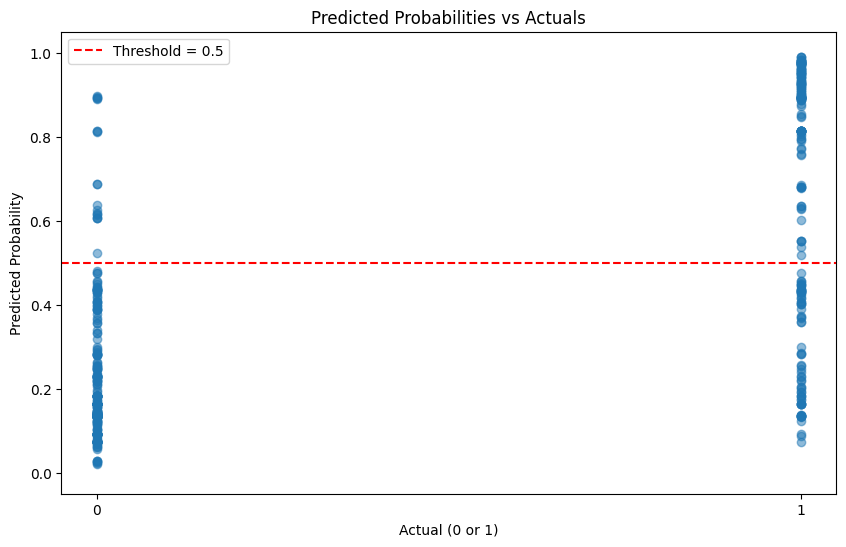

In [928]:
# Create figsize and scatter plot
plt.figure(figsize=(10,6))
plt.scatter(y_train.Survived.to_numpy(), train_probs, alpha=0.5)

# Threshold line
plt.axhline(y=0.5, color="r", linestyle="--", label=f"Threshold = {0.5}")

plt.title("Predicted Probabilities vs Actuals")
plt.xlabel("Actual (0 or 1)")
plt.ylabel("Predicted Probability")
plt.xticks([0,1])
plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()


## Train vs Val Curve
- Lets plot the Train vs Val curve to visualize and analyze overfitting vs undefitting

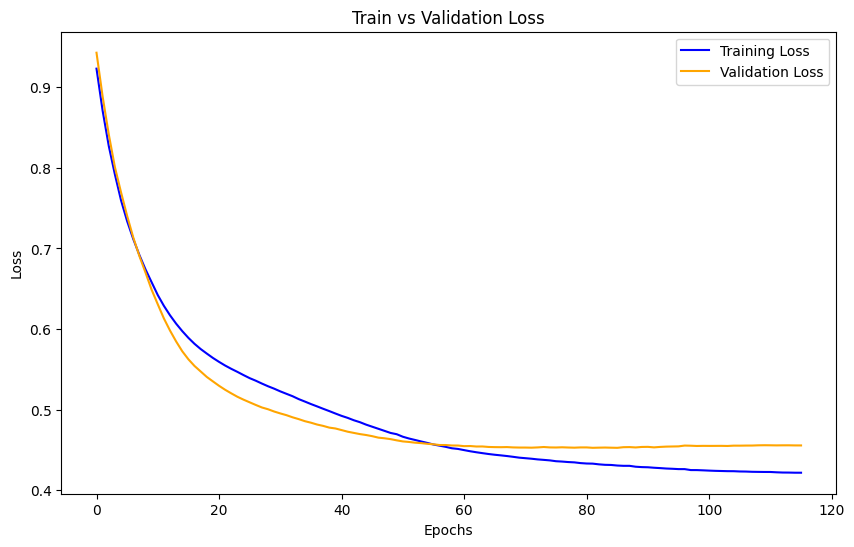

In [929]:
plt.figure(figsize=(10,6))
plt.plot(model.history.history["loss"], label="Training Loss", color="blue")
plt.plot(model.history.history["val_loss"], label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

## Test Dataset
- Now lets create our test dataset to generate the predictions we will submit.
- Start by importing the test.csv into a pandas dataframe.
- We will then create the class_group and age_group.

In [930]:
df_test = pd.read_csv("../titanic_data/test.csv")

# Create the class_group and the age_group engineered feature.
df_test["class_group"] = df_test.Pclass.map({1: "Upper", 2: "Middle", 3: "Lower"})
df_test["age_group"] = pd.cut(df_test.Age, bins=[-np.inf, 30, 60, np.inf], labels=["young", "middle", "old"], right=True)

df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,class_group,age_group
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Lower,middle
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Lower,middle
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Middle,old
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Lower,young
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Lower,young


## Test NaN Values
- We need to fill all NaN values just like we did in our train and val dataset.
- We will do so in the following order: embarked, age, cabin, others.

In [931]:
# Lets fill Embarked utilizing the top Embarkment/port observed by class and gender 
embarked_by_class_gender = ( 
    df_test.groupby(["class_group", "Sex", "Embarked"], observed=True)
    .size() 
    .reset_index(name='n') 
) 

# Extract top Embarkments/ports
top_embarkments = ( 
    embarked_by_class_gender 
    .sort_values(["class_group", "Sex", "n", "Embarked"], ascending=[True, True, False, True]) 
    .drop_duplicates(subset=["class_group", "Sex"], keep="first") 
    .rename(columns={'Embarked': 'top_embarked', 'n': 'top_count'})
    .reset_index(drop=True) 
) 

X_test = df_test.merge(top_embarkments, on=["class_group", "Sex"], how="left") 
X_test.Embarked = X_test.Embarked.fillna(X_test.top_embarked) 
X_test.drop(columns=["top_count", "top_embarked"], inplace=True) 

print(X_test.isna().sum()) # Embarked should be 0

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
class_group      0
age_group       86
dtype: int64


In [932]:
# Lets fill Age utilizing the top age observed by class, gender, and embarkment 
age_by_class_gender = ( 
    X_test.groupby(["class_group", "Sex", "Embarked", "Age"], observed=True)
    .size()
    .reset_index(name='n') 
) 

# Extract the top ages
top_ages = ( 
    age_by_class_gender
    .sort_values(["class_group", "Sex", "Embarked", "Age", "n"], ascending=[True, True, True, True, False]) 
    .drop_duplicates(subset=["class_group", "Sex", "Embarked"], keep="first") 
    .rename(columns={"Age": "top_age", "n": "top_count"}) 
    .reset_index(drop=True) 
) 

# Fill Age NaNs
X_test = X_test.merge(top_ages, on=["class_group", "Sex", "Embarked"], how="left") 
X_test.Age = X_test.Age.fillna(X_test.top_age) 
X_test.drop(columns=["top_count", "top_age"], inplace=True) 

# Lets reapply the Age bins to remove NaNs from age_group as well 
X_test["age_group"] = pd.cut( 
    X_test.Age, 
    bins = [-np.inf, 30, 60, np.inf], 
    labels = ["young", "middle", "old"], 
    right=True
) 

print(X_test.isna().sum()) # Age and age_group should be 0

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
class_group      0
age_group        0
dtype: int64


In [933]:
# The assignment of a cabin to a passenger was most likely affected by the passenger's socio-economic class and age
# Lets try to find a pattern, lets look group cabin by socio-economic class
# We will only use the first letter of the cabin
X_test.Cabin = X_test.Cabin.str.strip().str[0]

#Lets extract passangers avg per Cabin, grouped by socio-economic class, age group and sex
cabin_by_class = (
    X_test.groupby(["class_group", "age_group", "Sex", "Cabin"], observed=True, dropna=False)
    .size()
    .reset_index(name='n')
)

keys = ['class_group', 'age_group', 'Sex']
valid_cabins = cabin_by_class[cabin_by_class['Cabin'].notna()].copy()

# Extract top cabins per group
top_cabins_per_group = (
    valid_cabins
      .sort_values(keys + ['n', 'Cabin'], ascending=[True, True, True, False, True])
      .drop_duplicates(subset=keys, keep='first')
      .rename(columns={'Cabin': 'top_cabin', 'n': 'top_count'})
      .reset_index(drop=True)
)

# Fall back in case all NaNs cannot be filled by top_cabins_per_group
top_cabin_per_class = (
    valid_cabins
    .sort_values("class_group", ascending=[True])
    .drop_duplicates(subset=["class_group"], keep="first")
    .rename(columns={'Cabin': 'top_cabin', 'n': 'top_count'})
    .reset_index(drop=True)
)

# Fill NaN Cabin with the group's most common cabin
X_test = X_test.merge(top_cabins_per_group[['class_group', 'age_group', 'Sex', 'top_cabin']], on=keys, how='left')
X_test['Cabin'] = X['Cabin'].fillna(X_test['top_cabin'])
X_test.drop(columns=["top_cabin"], errors='ignore', inplace=True)

# Fallback in case there are still NaNs for Cabins
if X_test.Cabin.isna().sum() > 0:
    cabin_by_class = (
        X_test.groupby(["class_group", "Cabin"], observed=True, dropna=True)
        .size()
        .reset_index(name="n")
    )

    X_test = X_test.merge(top_cabin_per_class[['class_group', 'top_cabin']], on='class_group', how='left')
    X_test['Cabin'] = X_test['Cabin'].fillna(X_test['top_cabin'])

X_test.drop(columns=["top_cabin"], errors='ignore', inplace=True)

X_test.head(10)
print(X_test.isna().sum())

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin          0
Embarked       0
class_group    0
age_group      0
dtype: int64


In [934]:
# Lets fill fare utilizing the top fare observed by class
fare_by_class= ( 
    X_test.groupby(["class_group", "Fare"], observed=True)
    .size() 
    .reset_index(name='n') 
) 

# Extract top fares
top_fares = ( 
    fare_by_class 
    .sort_values(["class_group", "n", "Fare"], ascending=[True, False, True]) 
    .drop_duplicates(subset=["class_group"], keep="first") 
    .rename(columns={'Fare': 'top_fare', 'n': 'top_count'})
    .reset_index(drop=True) 
) 

# Fill all NaNs
X_test = X_test.merge(top_fares, on=["class_group"], how="left") 
X_test.Fare = X_test.Fare.fillna(X_test.top_fare) 
X_test.drop(columns=["top_count", "top_fare"], inplace=True) 

print(X_test.isna().sum())

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
class_group    0
age_group      0
dtype: int64


## Test Dataset Transformation
- Lets finalize the Test dataset by creating the appropriate categorical columns as one-hot encoded columns.
- We will also scale the Test feature dataset with z-score normalization.

In [935]:
# Lets create one-hot encoding for some columns for test_dataset 
deck_test = pd.get_dummies(X_test.Cabin.str.strip().str[0], prefix="Deck", dummy_na=True, dtype="uint8")
sex_test = pd.get_dummies(X_test.Sex, prefix="Sex", dummy_na=True, dtype="uint8")
port_test = pd.get_dummies(X_test.Embarked, prefix="port", dummy_na=True, dtype="uint8")
class_group_test = pd.get_dummies(X_test.class_group, prefix="class", dummy_na=True, dtype="uint8")
age_group_test = pd.get_dummies(X_test.age_group, prefix="age", dummy_na=True, dtype="uint8")

one_hot_encoded_test_f = pd.concat([deck_test, sex_test, port_test, class_group_test, age_group_test], axis=1)

missing_test_cols = [test_col for test_col in X_test.columns if test_col not in X_train.columns]

# Combine with X_test
X_test = pd.concat([X_test.drop(columns=["Sex", "Cabin", "Embarked", "class_group", "age_group"]), one_hot_encoded_test_f], axis=1)

# Add missing test cols
for col in missing_test_cols:
    X_test[col] = 0 # Only cols that will be missing after all transformations have been completed are the one-hot encoded features

# Remove any one-hot encoded columns that have NaN in their name.
for col in X_test.columns:
    if 'nan' in col.lower():
        X_test.drop(col, axis=1, inplace=True)

# I'm eliminating name and ticket as I believe these do not hold any relevance to a passenger's survival
X_test.drop(columns=["PassengerId", "Name", "Ticket"], inplace=True)
X_test = X_test.reindex(columns=X_train.columns)

print(X_test.isna().sum())

Pclass          0
SibSp           0
Parch           0
Fare            0
Deck_A          0
Deck_B          0
Deck_C          0
Deck_D          0
Deck_E          0
Deck_F          0
Deck_G          0
Sex_female      0
Sex_male        0
port_C          0
port_Q          0
port_S          0
class_Lower     0
class_Middle    0
class_Upper     0
age_young       0
age_middle      0
age_old         0
Deck_T          0
dtype: int64


In [936]:
# Normalize the test feature dataset with z-score.
X_test_scaled = scaler.transform(X_test)
test_probs = model.predict(X_test_scaled).reshape(-1)

# Apply threshold at 0.5
test_pred = (test_probs > 0.5).astype(int)

# Create submission dataset and export results as csv.
y_pred = pd.DataFrame(data=test_pred, columns=["Survived"])

X_test_passengers = df_test[["PassengerId"]]

test_preds = pd.concat([X_test_passengers["PassengerId"], y_pred], axis=1).reset_index(drop=True)


test_preds.to_csv("../titanic_data/preds.csv", index=False)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
